### Andrea Tondella - MBD O2
##### 18 march 2018
## Pump it Up: Data Mining the Water Table

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

www.drivendata.org

**user:** andreatondella

## Notebook

This notebook is structured in HOW MANY different sections:

+ **Data Cleaning:** where all the variables are inspected and the necessary steps are taken in order to remove missing values, correct errors, remove redundant features and apply the necessary transformations.
+ **Feature Engineering:** where some new features are created from the combination of other existing features.
+ **Exploration:** where the relation between some interesting variables status_group is analyzed.
+ **PCA and LDA:** where some dimensionality reduction techniques are tested in an attempt to visualize the dataset in 2 and 3 dimensions.
+ **Baseline Models:** where the following models are fitted to the data to get a baseline score: Random Forest, XGBoost, KNN, LDA and KNN after LDA.
+ **Hyperparameter tuning:** where the parameters of Random Rorest and XGBoost are tuned by means of iterated random searches. **Best Score Overall (0.8201)** obtained by random forest after parameter tuning.
+ **Model Stacking:** where Random Forest and XGBoost after parameter tuning are stacked by means of a random forest.
+ **Specialized Random Forests:** where three different Random Rorests are trained to predict a particular status_group in a "one vs the rest" fashion. The three forests are then stacked together by means of a logistic regression.


In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

# Settings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

# Display options
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10

In [2]:
# Setting pathnames
pathname_test_set = ("/Users/andrea/iE/SecondTerm/ML2/Assignments/Pump_it_up/Test_set_values.csv")
pathname_train_set = ("/Users/andrea/iE/SecondTerm/ML2/Assignments/Pump_it_up/Training_set_values.csv")
pathname_train_labels = ("/Users/andrea/iE/SecondTerm/ML2/Assignments/Pump_it_up/Training_set_labels.csv")

In [3]:
# Reading csv files
test_data = pd.read_csv(pathname_test_set)
train_data = pd.read_csv(pathname_train_set)
train_labels = pd.read_csv(pathname_train_labels)

In [4]:
# Taking a first look
test_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [5]:
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [7]:
# train and test have the same numer of columns?
len(train_data.columns) == len(test_data.columns)

True

In [8]:
# merging train and test before cleaning and transforming the data
all_data = train_data.append(test_data)

# the merge is correct?
len(all_data) == (len(train_data)+len(test_data))

True

In [9]:
# looking at label distribution
train_labels.groupby(['status_group']).size()

status_group
functional                 32259
functional needs repair     4317
non functional             22824
dtype: int64

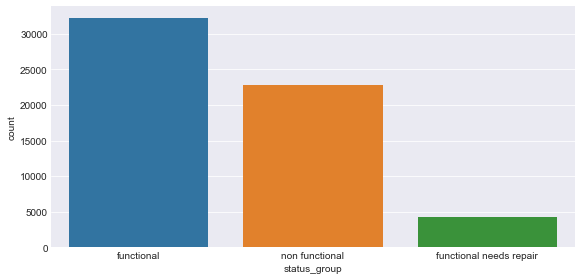

In [10]:
sns.factorplot('status_group', data=train_labels, aspect=2, kind='count');

In [11]:
# Very small amount of 'functional needs repair'. It will probably be the hardest to predict

## Data Cleaning

In [12]:
# Looking at the columns
list(all_data)

['id',
 'amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [13]:
# counting NAs per column
all_data.isnull().sum()\[:10]

scheme_name          35258
scheme_management     4846
installer             4532
funder                4504
public_meeting        4155
permit                3793
subvillage             470
ward                     0
lga                      0
district_code            0
dtype: int64

In [14]:
# Few variables have NAs, let's go through each of the variables to spot some other possible problems

In [15]:
# --- Subvillage ---

# top 20 subvillages
all_data.groupby(['subvillage'])['id'].count().sort_values(ascending=False)[:10]

subvillage
Shuleni       646
Majengo       631
Madukani      629
Kati          467
Mtakuja       322
Sokoni        294
M             243
Muungano      215
Mbuyuni       210
Songambele    194
Name: id, dtype: int64

In [16]:
# Let's first impute the NAs to Unknown
all_data.subvillage.fillna(value='other', inplace=True)

# And all the values which are clear errors (1, A, M, N, ...)
all_data.loc[all_data.subvillage.str.len() == 1, 'subvillage'] = 'other'

In [17]:
# --- Amount tsh: amount of water in the basin ---

# Some significant values:
print('max:',all_data.amount_tsh.max())
print('min:',all_data.amount_tsh.min())
print('mean:',all_data.amount_tsh.mean())
print('median:',all_data.amount_tsh.median())

max: 350000.0
min: 0.0
mean: 318.6857043771044
median: 0.0


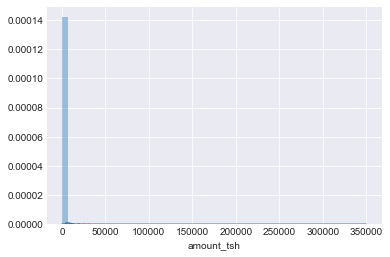

In [18]:
# Distribution
sns.distplot(all_data.amount_tsh)

In [19]:
# Too many zeros, let's drop the column
all_data = all_data.drop('amount_tsh', axis=1)

In [20]:
# --- Date recorded: date in which the row was inserted ---

# First look
all_data.date_recorded[:10]

0    2011-03-14
1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13
5    2011-03-13
6    2012-10-01
7    2012-10-09
8    2012-11-03
9    2011-08-03
Name: date_recorded, dtype: object

In [21]:
# Let's split it to year and month
all_data['year_recorded'] = all_data.date_recorded.str.slice(0,4)
all_data['month_recorded'] = all_data.date_recorded.str.slice(5,7)

# Convert them to integer
all_data.year_recorded = all_data.year_recorded.astype('float', errors='ignore')
all_data.month_recorded = all_data.month_recorded.astype('float', errors='ignore')

# And drop the date column
all_data = all_data.drop('date_recorded', axis=1)

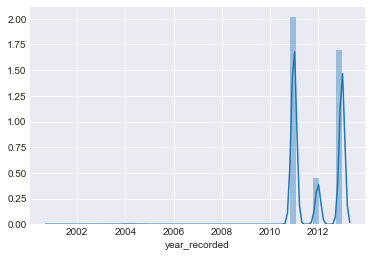

In [22]:
# Distribution
sns.distplot(all_data.year_recorded);

In [23]:
all_data.groupby(['year_recorded'])['id'].count()

year_recorded
2001.0        1
2002.0        1
2004.0       41
2011.0    35908
2012.0     8089
2013.0    30210
Name: id, dtype: int64

In [24]:
# I suppose 2001, 2002 and 2004 are errors
all_data.loc[all_data.year_recorded == 2001.0, 'year_recorded'] = 2011
all_data.loc[all_data.year_recorded == 2002.0, 'year_recorded'] = 2012
all_data.loc[all_data.year_recorded == 2004.0, 'year_recorded'] = 2014

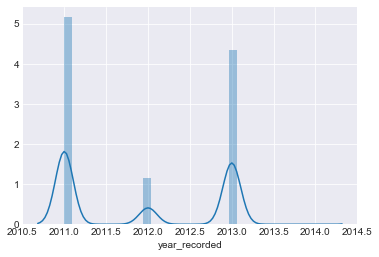

In [25]:
# New distribution
sns.distplot(all_data.year_recorded)

In [26]:
# --- Funder ---
all_data.groupby(['funder']).size().sort_values(ascending=False)[:10]

funder
Government Of Tanzania    11299
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
Kkkt                       1623
World Vision               1562
Unicef                     1324
Tasaf                      1136
Dhv                        1065
dtype: int64

In [27]:
# Let's impute them as other for now
all_data.funder.fillna('other', inplace=True)

# And all the values which are clear errors (1, A, M, N, ...)
all_data.loc[all_data.funder.str.len() == 1, 'funder'] = 'other'

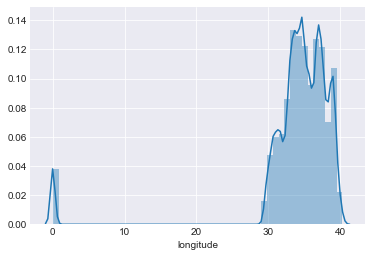

In [28]:
# --- Longitude ---
sns.distplot(all_data.longitude)

In [29]:
# Some data has longitude equal zero, which is not possible

# Let's set the 0 values to NA
all_data.loc[all_data.longitude == 0, 'longitude'] = np.nan
all_data.longitude.isnull().sum()

2269

In [30]:
# And let's impute the missing coordinates with the average longitude of the subvillage they belong
all_data.longitude.fillna(all_data.groupby(['subvillage'])['longitude'].transform('mean'), inplace=True)
all_data.longitude.isnull().sum()

1410

In [31]:
# Still some NAs, let's impute them based on ward (the smallest division after subvillage)
all_data.longitude.fillna(all_data.groupby(['ward'])['longitude'].transform('mean'), inplace=True)
all_data.longitude.isnull().sum()

37

In [32]:
# Still some, keep on imputing by geographical divisions, going wider and wider
all_data.longitude.fillna(all_data.groupby(['lga'])['longitude'].transform('mean'), inplace=True)
all_data.longitude.isnull().sum()

0

In [33]:
# Let's round longitude to 2 decimals
all_data.longitude = all_data.longitude.round(2)

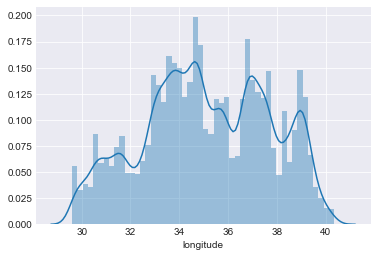

In [34]:
sns.distplot(all_data.longitude) # Much better now

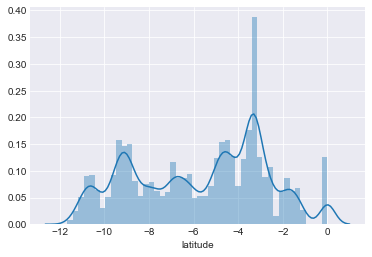

In [35]:
# --- Latitude ---

# Let's round latitude to 2 decimals
all_data.latitude = all_data.latitude.round(2)

sns.distplot(all_data.latitude)

In [36]:
# Again a few 0. Tanzania is all below the equator, therefore 0 must be wrong
# Let's set the 0 values to NA

all_data.loc[all_data.latitude == 0, 'latitude'] = np.nan
all_data.latitude.isnull().sum()

2269

In [37]:
# And let's impute the missing coordinates with the average longitude of the subvillage they belong
all_data.latitude.fillna(all_data.groupby(['subvillage'])['latitude'].transform('mean'), inplace=True)
all_data.latitude.isnull().sum()

1410

In [38]:
# Still some NAs, let's impute them based on ward (the smallest division after subvillage)
all_data.latitude.fillna(all_data.groupby(['ward'])['latitude'].transform('mean'), inplace=True)
all_data.latitude.isnull().sum()

37

In [39]:
# Still some, keep on imputing by geographical divisions, going wider and wider
all_data.latitude.fillna(all_data.groupby(['lga'])['latitude'].transform('mean'), inplace=True)
all_data.latitude.isnull().sum()

0

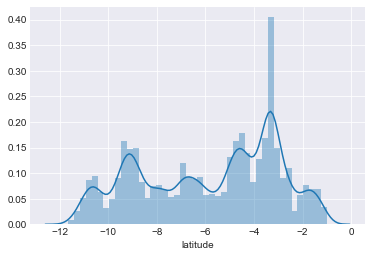

In [40]:

sns.distplot(all_data.latitude) # Much better now

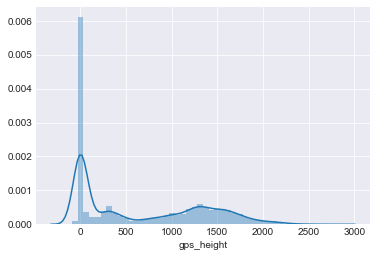

In [41]:
# --- GPS Height ---
sns.distplot(all_data.gps_height)

In [42]:
# Too many zeros, let's do as for latitude and longitude
all_data.loc[all_data.gps_height == 0, 'gps_height'] = np.nan
all_data.gps_height.isnull().sum()

25649

In [43]:
# by subvillage
all_data.gps_height.fillna(all_data.groupby(['subvillage'])['gps_height'].transform('mean'), inplace=True)
all_data.gps_height.isnull().sum()

19108

In [44]:
# by ward
all_data.gps_height.fillna(all_data.groupby(['ward'])['gps_height'].transform('mean'), inplace=True)
all_data.gps_height.isnull().sum()

2222

In [45]:
# by lga
all_data.gps_height.fillna(all_data.groupby(['lga'])['gps_height'].transform('mean'), inplace=True)
all_data.gps_height.isnull().sum()

114

In [46]:
# by region
all_data.gps_height.fillna(all_data.groupby(['region_code'])['gps_height'].transform('mean'), inplace=True)
all_data.gps_height.isnull().sum()

0

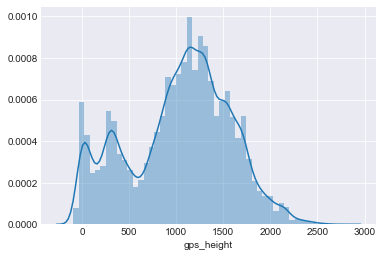

In [47]:
# Good now
sns.distplot(all_data.gps_height)

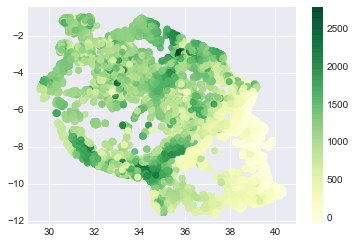

In [48]:
# Plot of gps coordinates colored by gps height. Seems correct
plt.scatter(all_data.longitude, all_data.latitude, alpha = .8, c = all_data.gps_height, cmap = 'YlGn')
cbar = plt.colorbar()

In [49]:
# --- Installer ---
all_data.groupby(['installer'])['id'].count().sort_values(ascending=False)[:10]

installer
DWE           21751
Government     2282
RWE            1498
Commu          1347
DANIDA         1305
KKKT           1120
Hesawa         1070
0               980
TCRS            887
CES             765
Name: id, dtype: int64

In [50]:
# Let's impute them as unknown for now
all_data.installer.fillna('other', inplace=True)

# And all the values which are clear errors (1, A, M, N, ...)
all_data.loc[all_data.installer.str.len() == 1, 'installer'] = 'other'

all_data.installer.isnull().sum()

0

In [51]:
# --- wpt_name ---
all_data.groupby(['wpt_name']).size().sort_values(ascending=False)[1:10]

wpt_name
Shuleni            2183
Zahanati           1034
Msikitini           647
Kanisani            390
Sokoni              328
Bombani             323
Ofisini             321
School              260
Shule Ya Msingi     247
dtype: int64

In [52]:
# Too many different, we can drop wpt_name
all_data = all_data.drop('wpt_name', axis=1)

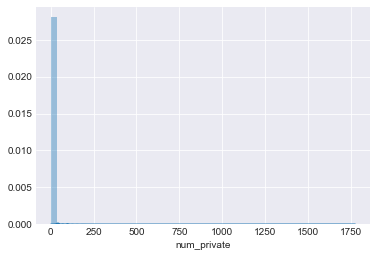

In [53]:
# --- Num private: no descrition of this ---
sns.distplot(all_data.num_private)

In [54]:
# Let's drop the feature
all_data = all_data.drop('num_private', axis=1)

In [55]:
# --- Basin: geographical basin ---
all_data.groupby(['basin']).size() # Everything good here

basin
Internal                    9642
Lake Nyasa                  6332
Lake Rukwa                  3059
Lake Tanganyika             8052
Lake Victoria              12871
Pangani                    11143
Rufiji                      9987
Ruvuma / Southern Coast     5587
Wami / Ruvu                 7577
dtype: int64

In [56]:
# --- Region ---
all_data.groupby(['region']).size().sort_values(ascending=False)[:10] # Everything good here

region
Iringa         6599
Shinyanga      6293
Mbeya          5758
Kilimanjaro    5494
Morogoro       5038
Kagera         4174
Arusha         4111
Mwanza         3897
Kigoma         3533
Pwani          3331
dtype: int64

In [57]:
# --- Region code ---
all_data.groupby(['region_code']).size().sort_values(ascending=False)[:10] # Everything good here

region_code
11    6608
17    6334
12    5759
3     5494
5     5079
18    4183
19    3824
2     3709
16    3533
10    3306
dtype: int64

In [58]:
all_data.groupby(['region','region_code']).size()[:10]

region         region_code
Arusha         2              3709
               24              402
Dar es Salaam  7              1020
Dodoma         1              2779
Iringa         11             6599
Kagera         18             4174
Kigoma         16             3533
Kilimanjaro    3              5494
Lindi          8               375
               18                9
dtype: int64

In [59]:
# region_code has more informations, let's drop region column
all_data = all_data.drop('region', axis=1)

In [60]:
# --- District code ---
all_data.groupby(['district_code']).size().sort_values(ascending=False)[:10] # Everything good here

district_code
1     15299
2     13929
3     12521
4     11253
5      5428
6      5108
7      4166
8      1282
30     1256
33     1063
dtype: int64

In [61]:
all_data.groupby(['region_code','district_code']).size()[:10]

region_code  district_code
1            0                  27
             1                1107
             3                 460
             4                 439
             5                 467
             6                 279
2            1                 226
             2                1460
             3                 143
             5                 245
dtype: int64

In [62]:
# district code repeats in different regions, let's drop it
all_data = all_data.drop('district_code', axis=1)

In [63]:
# --- Lga ---
all_data.groupby(['lga']).size().sort_values(ascending=False)[:10] 

lga
Njombe          3128
Moshi Rural     1566
Arusha Rural    1521
Bariadi         1485
Rungwe          1381
Kilosa          1368
Kasulu          1322
Mbozi           1286
Bagamoyo        1263
Meru            1244
dtype: int64

In [64]:
all_data.groupby(['region_code', 'lga']).size()[:10] # Everything good here

region_code  lga         
1            Bahi             279
             Chamwino         439
             Dodoma Urban     467
             Kondoa           644
             Kongwa           460
             Mpwapwa          490
2            Arusha Rural    1521
             Arusha Urban      82
             Longido          391
             Meru            1244
dtype: int64

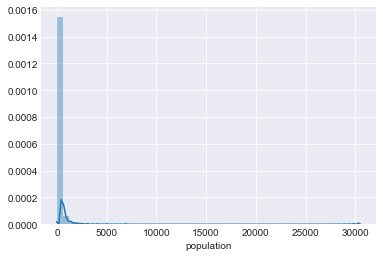

In [65]:
# --- Population ---
sns.distplot(all_data.population)

In [66]:
all_data.groupby(['population']).size().sort_values(ascending=False)[:10]
# Zero is not really possible, let's impute again by averages

population
0      26834
1       8782
200     2370
150     2328
250     2087
300     1842
50      1437
100     1419
500     1274
350     1252
dtype: int64

In [67]:
# Too many zeros, let's impute them by averages as for the geographical coordinates
all_data.loc[all_data.population == 0, 'population'] = np.nan
all_data.population.isnull().sum()

26834

In [68]:
# by subvillage
all_data.population.fillna(all_data.groupby(['subvillage'])['population'].transform('median'), inplace=True)
all_data.population.isnull().sum()

19359

In [69]:
# by ward
all_data.population.fillna(all_data.groupby(['ward'])['population'].transform('median'), inplace=True)
all_data.population.isnull().sum()

2364

In [70]:
# by lga
all_data.population.fillna(all_data.groupby(['lga'])['population'].transform('median'), inplace=True)
all_data.population.isnull().sum()

114

In [71]:
# by region_code
all_data.population.fillna(all_data.groupby(['region_code'])['population'].transform('median'), inplace=True)
all_data.population.isnull().sum()

0

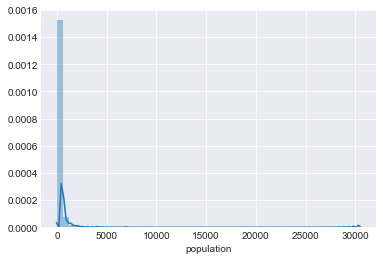

In [72]:
# distribution still vety skewed to the right => taking the log
sns.distplot(all_data.population)

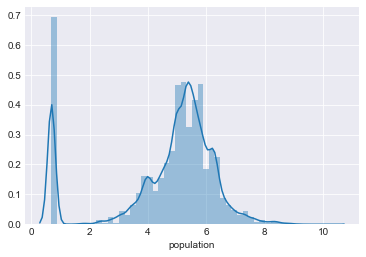

In [73]:
# Looks better now, still not the best
sns.distplot(np.log1p(all_data.population));

In [74]:
# Let's create a new column with the log of population
all_data['population_log'] = np.log1p(all_data.population)

# And drop population
all_data = all_data.drop('population', axis=1)

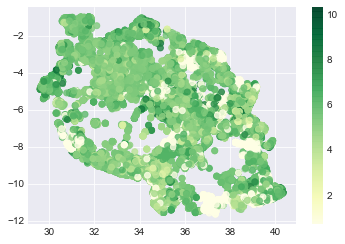

In [75]:
# Population density by geograohical coordinates
plt.scatter(all_data.longitude, all_data.latitude, alpha = .8, c = all_data.population_log, cmap = 'YlGn')
cbar = plt.colorbar()

In [76]:
# --- Public meeting ---
all_data.groupby(['public_meeting']).size()

public_meeting
False     6346
True     63749
dtype: int64

In [77]:
# Setting True to 1 and False to 0
all_data.loc[all_data.public_meeting == True, 'public_meeting'] = 1
all_data.loc[all_data.public_meeting == False, 'public_meeting'] = 0

# convert the column to integer
all_data.public_meeting = all_data.public_meeting.astype('int', errors='ignore')

# The ratio True:false is 10:1, we can safely impute all the NAs as True
all_data.public_meeting.fillna(1, inplace=True)
all_data.public_meeting.isnull().sum()

0

In [78]:
# --- Recorded by ---
all_data.recorded_by.unique() 

array(['GeoData Consultants Ltd'], dtype=object)

In [79]:
# There is only one institution recording, we can drop the column
all_data = all_data.drop('recorded_by', axis=1)

In [80]:
# --- Management ---

# let's impute them NAs as other for now
all_data.scheme_management.fillna('other', inplace=True)
all_data.scheme_management.isnull().sum()

0

In [81]:
# --- Scheme management ---
all_data.groupby(['scheme_management']).size().sort_values(ascending=False)[:10]

scheme_management
VWC                 45917
WUG                  6496
other                4846
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
dtype: int64

In [82]:
# --- Scheme name ---
all_data.groupby(['scheme_name']).size().sort_values(ascending=False)[:10]

scheme_name
K                              858
None                           794
Borehole                       704
Chalinze wate                  501
M                              490
DANIDA                         483
Government                     395
Ngana water supplied scheme    335
wanging'ombe water supply s    323
Bagamoyo wate                  296
dtype: int64

In [83]:
all_data.groupby(['scheme_management','scheme_name']).size()[:10]

scheme_management  scheme_name              
Company            BFFS                           1
                   BSF water supplying            1
                   Bagamoyo Wate                 76
                   Bagamoyo wate                272
                   Borehole                       1
                   Borehole drilling project      1
                   Bulamba piped scheme           3
                   Burieni water supply           1
                   Doe water supply               4
                   EKTM 2 water  supply           1
dtype: int64

In [84]:
all_data.groupby(['scheme_management','management']).size()[:10]

scheme_management  management      
Company            company             848
                   other                 2
                   parastatal           30
                   private operator    287
                   vwc                 173
                   wug                   1
None               vwc                   1
Other              other               690
                   parastatal            1
                   private operator     78
dtype: int64

In [85]:
# Let's drop scheme_name, too many levels
all_data = all_data.drop('scheme_name', axis=1)

In [86]:
# --- permit ---
all_data.groupby(['permit'])['id'].count().sort_values(ascending=False)

permit
True     48606
False    21851
Name: id, dtype: int64

In [87]:
# we can drop the column
all_data = all_data.drop('permit', axis=1)

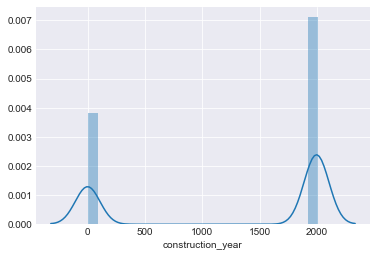

In [88]:
# --- Construction year ---
sns.distplot(all_data.construction_year) 

In [89]:
# A lot of zeros, let's go again with geographical medians
all_data.loc[all_data.construction_year == 0, 'construction_year'] = np.nan
all_data.construction_year.isnull().sum()

25969

In [90]:
# by subvillage
all_data.construction_year.fillna(all_data.groupby(['subvillage'])['construction_year'] \
                                  .transform('median'), inplace=True)

all_data.construction_year.isnull().sum()

18875

In [91]:
# by ward
all_data.construction_year.fillna(all_data.groupby(['ward'])['construction_year'] \
                                  .transform('median'), inplace=True)

all_data.construction_year.isnull().sum()

2205

In [92]:
# by lga
all_data.construction_year.fillna(all_data.groupby(['lga'])['construction_year'] \
                                  .transform('median'), inplace=True)

all_data.construction_year.isnull().sum()

114

In [93]:
# by region_code
all_data.construction_year.fillna(all_data.groupby(['region_code'])['construction_year'] \
                                  .transform('median'), inplace=True)

all_data.construction_year.isnull().sum()

0

In [94]:
# let's remove decimals from the year 
all_data.construction_year = all_data.construction_year.round(0)

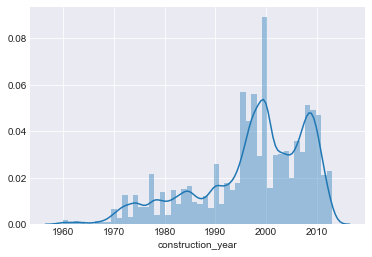

In [95]:
# Let's plot it again
sns.distplot(all_data.construction_year) # Good now

In [96]:
# --- Extraction type ---
all_data.groupby(['extraction_type','extraction_type_group','extraction_type_class']).size()[:10] # All good here

extraction_type  extraction_type_group  extraction_type_class
afridev          afridev                handpump                  2208
cemo             other motorpump        motorpump                  108
climax           other motorpump        motorpump                   41
gravity          gravity                gravity                  33263
india mark ii    india mark ii          handpump                  3029
india mark iii   india mark iii         handpump                   135
ksb              submersible            submersible               1790
mono             mono                   motorpump                 3628
nira/tanira      nira/tanira            handpump                 10205
other            other                  other                     8102
dtype: int64

In [97]:
# Let's keep only extraction_type_class
all_data = all_data.drop('extraction_type', axis=1)
all_data = all_data.drop('extraction_type_group', axis=1)

# And all the values which are clear errors (1, A, M, N, ...)
all_data.loc[all_data.scheme_management == 'None', 'scheme_management'] = 'other'

In [98]:
# --- Payment and payment type---
all_data.groupby(['payment','payment_type']).size() # All good here

payment                payment_type
never pay              never pay       31712
other                  other            1314
pay annually           annually         4570
pay monthly            monthly         10397
pay per bucket         per bucket      11266
pay when scheme fails  on failure       4842
unknown                unknown         10149
dtype: int64

In [99]:
# These two are redundant, let's drop payment
all_data = all_data.drop('payment', axis=1)

In [100]:
# --- Water quality ---
all_data.groupby(['water_quality','quality_group']).size() # All good here

water_quality       quality_group
coloured            colored            623
fluoride            fluoride           244
fluoride abandoned  fluoride            23
milky               milky             1005
salty               salty             6082
salty abandoned     salty              423
soft                good             63505
unknown             unknown           2345
dtype: int64

In [101]:
# Water quality has more information, let's keep it and drop quality_group
all_data = all_data.drop('quality_group', axis=1)

In [102]:
# --- Quantity and quantity_group ---
all_data.groupby(['quantity','quantity_group'])['id'].size() # All good here

quantity      quantity_group
dry           dry                7782
enough        enough            41522
insufficient  insufficient      18896
seasonal      seasonal           5075
unknown       unknown             975
Name: id, dtype: int64

In [103]:
# The two columns are equal, let's drop quantity_group
all_data = all_data.drop('quantity_group', axis=1)

In [104]:
# --- Source ---
all_data.groupby(['source','source_type','source_class']).size() # All good here

source                source_type           source_class
dam                   dam                   surface           840
hand dtw              borehole              groundwater      1108
lake                  river/lake            surface           950
machine dbh           borehole              groundwater     13822
other                 other                 unknown           261
rainwater harvesting  rainwater harvesting  surface          2863
river                 river/lake            surface         11964
shallow well          shallow well          groundwater     21140
spring                spring                groundwater     21216
unknown               other                 unknown            86
dtype: int64

In [105]:
# Source and sopurce_type are equal similar, let's keep source as it has more informations
all_data = all_data.drop('source_type', axis=1)

In [106]:
# --- Water point type ---
all_data.groupby(['waterpoint_type','waterpoint_type_group']).size() # All good here

waterpoint_type              waterpoint_type_group
cattle trough                cattle trough              150
communal standpipe           communal standpipe       35628
communal standpipe multiple  communal standpipe        7611
dam                          dam                          8
hand pump                    hand pump                21884
improved spring              improved spring            959
other                        other                     8010
dtype: int64

In [107]:
# The two columns are equal, let's drop waterpoint_type_group
all_data = all_data.drop('waterpoint_type_group', axis=1)

## Feature Engineering

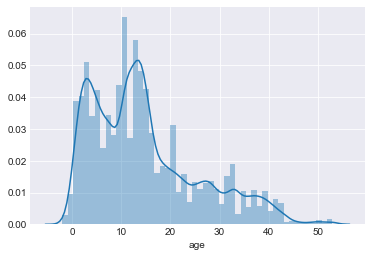

In [108]:
# --- Age column ---

# Let's compute the age when the status was recorded as year_recorded - year_built
all_data['age'] = all_data.year_recorded - all_data.construction_year

sns.distplot(all_data.age)

In [109]:
# Some ages are < 0 which is not possible, let's impute those to age 1
all_data.loc[all_data.age < 0, 'age'] = 1 

In [110]:
# --- season ---

# Jan and Feb short dry season
# long rains lasts during about March, April and May 
# long dry season lasts throughout June, July, August, September and October 
# During November and December there's another rainy season: the 'short rains'

all_data.loc[(all_data.month_recorded <= 2) & (all_data.month_recorded >= 1), 'season'] = 1
all_data.loc[(all_data.month_recorded <= 5) & (all_data.month_recorded >= 3), 'season'] = 2
all_data.loc[(all_data.month_recorded <= 10) & (all_data.month_recorded >= 6), 'season'] = 3
all_data.loc[(all_data.month_recorded <= 12) & (all_data.month_recorded >= 11), 'season'] = 4

# let's see the column
all_data.groupby(['season']).size()

season
1.0    23384
2.0    27802
3.0    20610
4.0     2454
dtype: int64

## Exploration

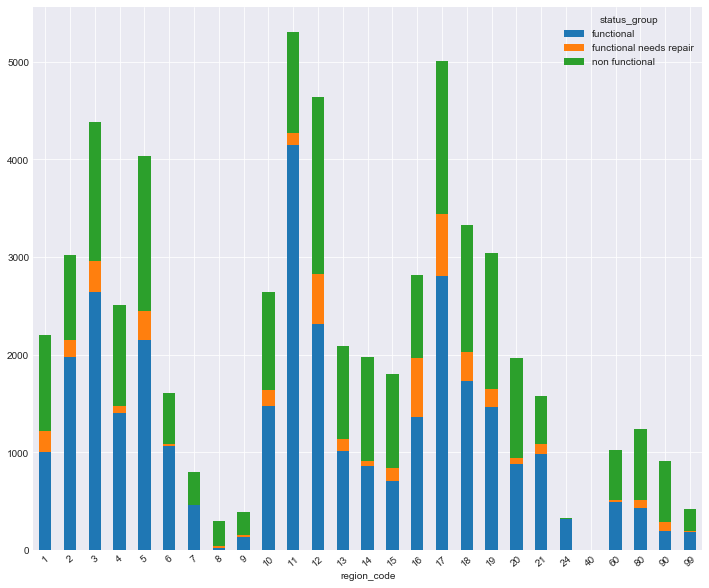

In [111]:
# Let's look at some of the variables with respect to status group

# Creating a df for plotting by merging train data and labels
plot_df = all_data[0:len(train_data)]
plot_df = plot_df.merge(train_labels, how='inner', on='id')

# Different regions affect the status?
plot = plot_df.groupby(['region_code', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

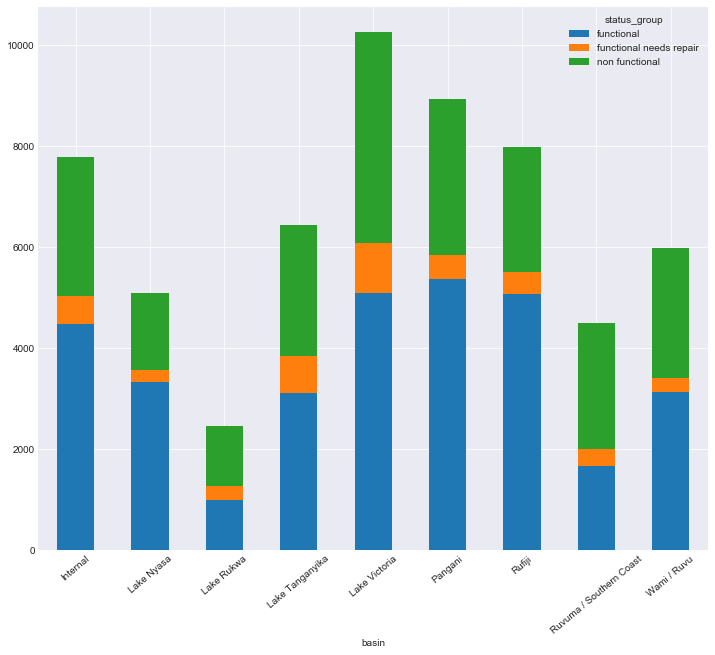

In [112]:
# Different basin affect the status?
plot = plot_df.groupby(['basin', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

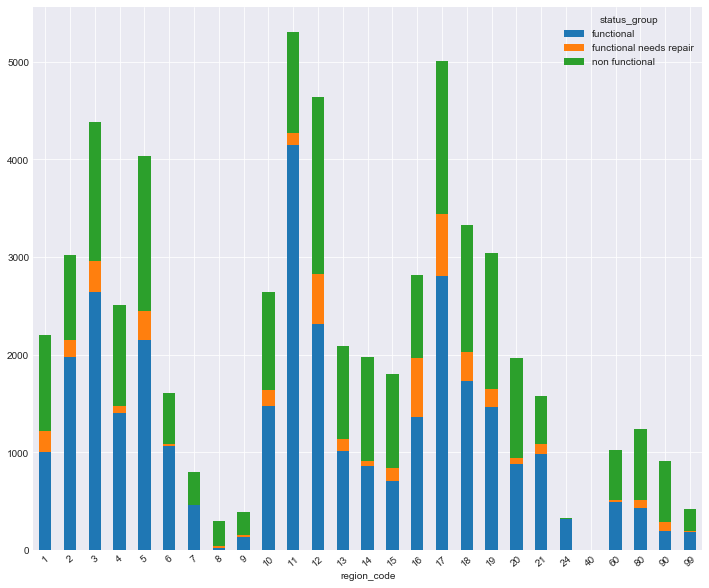

In [113]:
# Different region affect the status?
plot = plot_df.groupby(['region_code', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

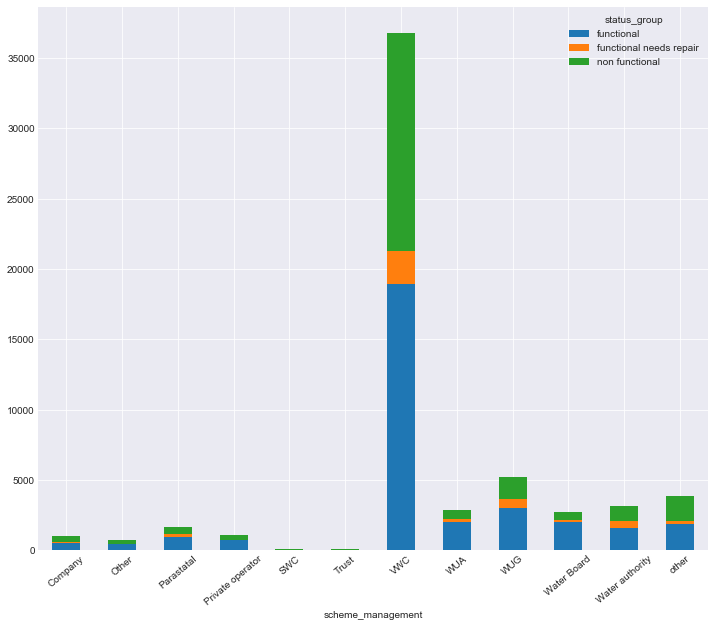

In [114]:
# Different scheme_management affect the status?
plot = plot_df.groupby(['scheme_management', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

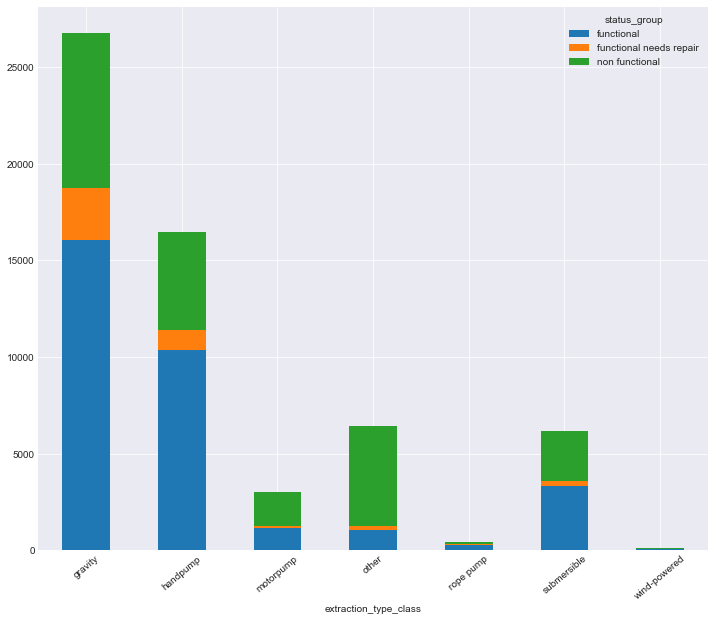

In [115]:
# Different extraction_type_class affect the status?
plot = plot_df.groupby(['extraction_type_class', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

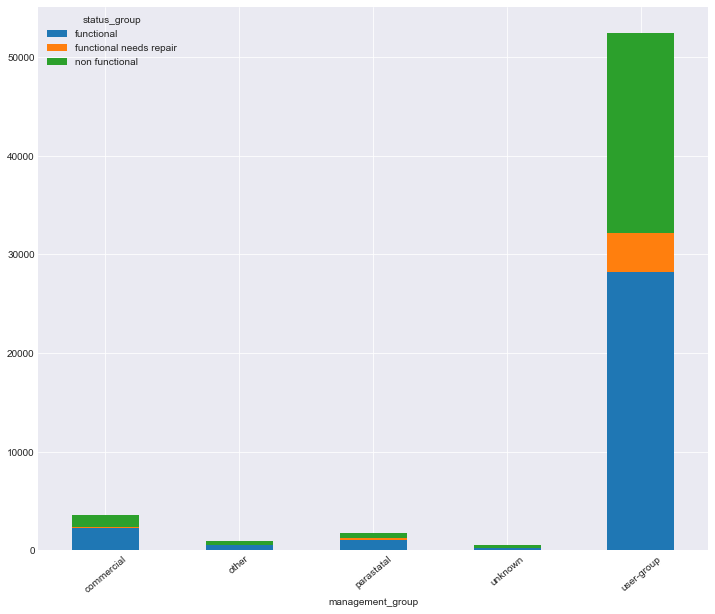

In [116]:
# Different management_group affect the status?
plot = plot_df.groupby(['management_group', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

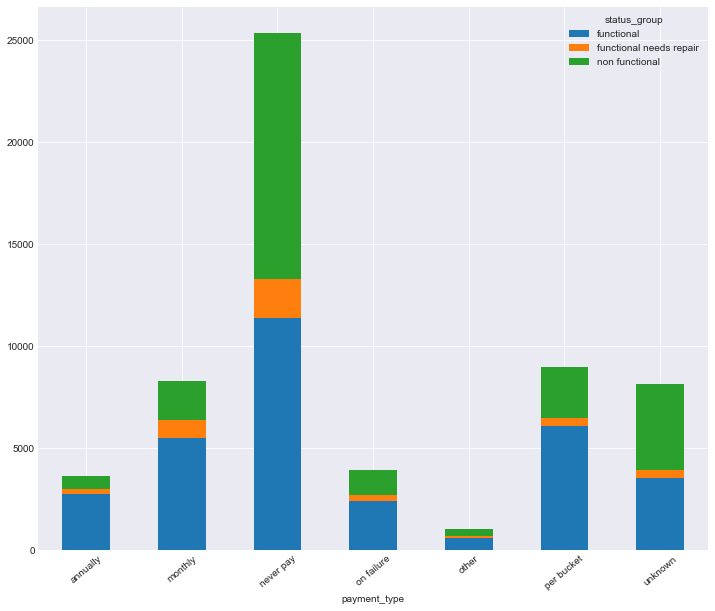

In [117]:
# Different extraction_type_class affect the status?
plot = plot_df.groupby(['payment_type', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

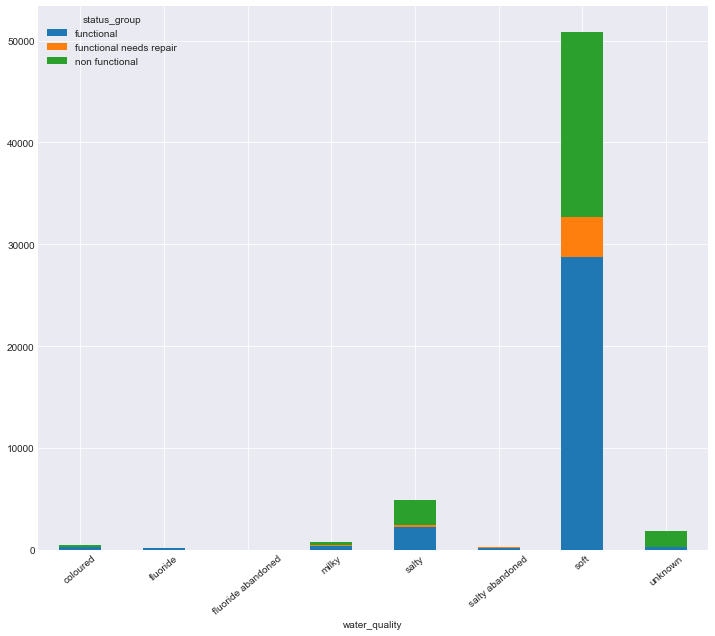

In [118]:
# Different water quality affect the status?
plot = plot_df.groupby(['water_quality', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

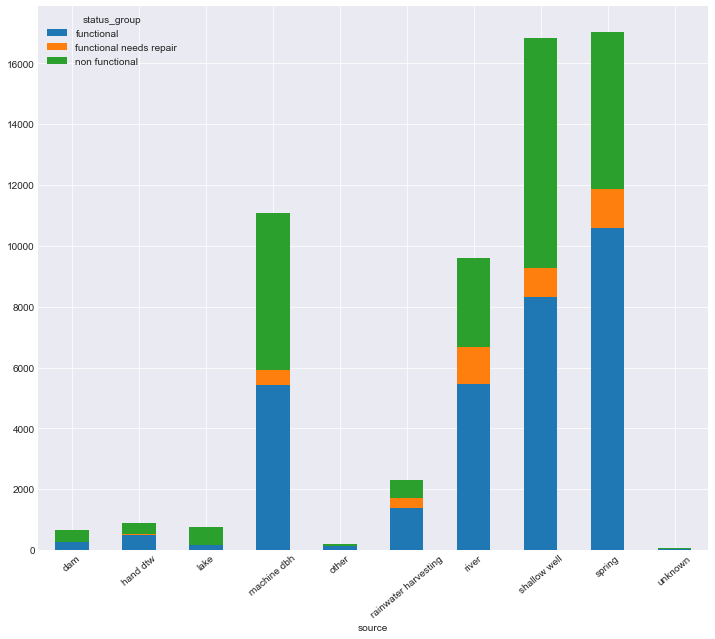

In [119]:
# Different sources affect the status?
plot = plot_df.groupby(['source', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

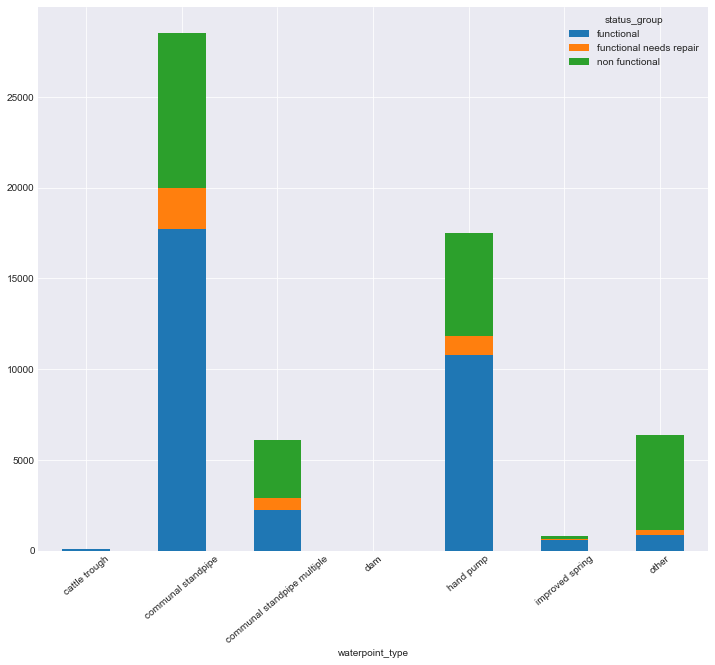

In [120]:
# Different waterpoints affect the status?
plot = plot_df.groupby(['waterpoint_type', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

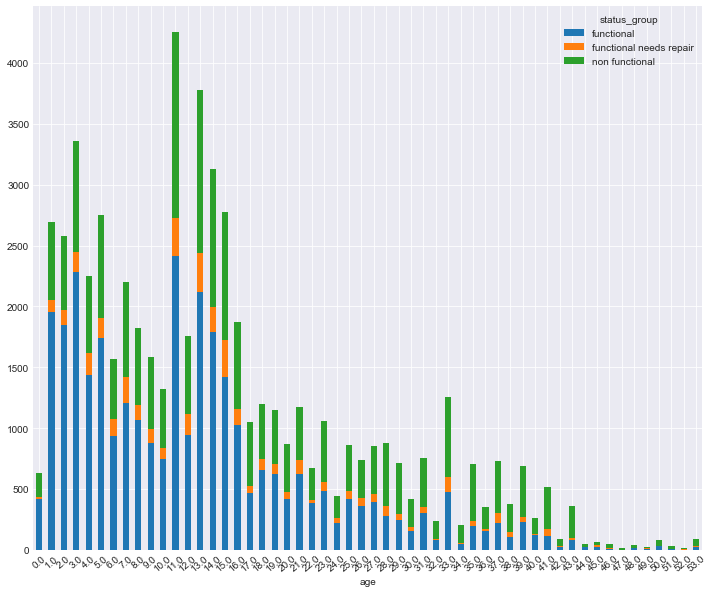

In [121]:
# Different ages affect the status?
plot = plot_df.groupby(['age', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

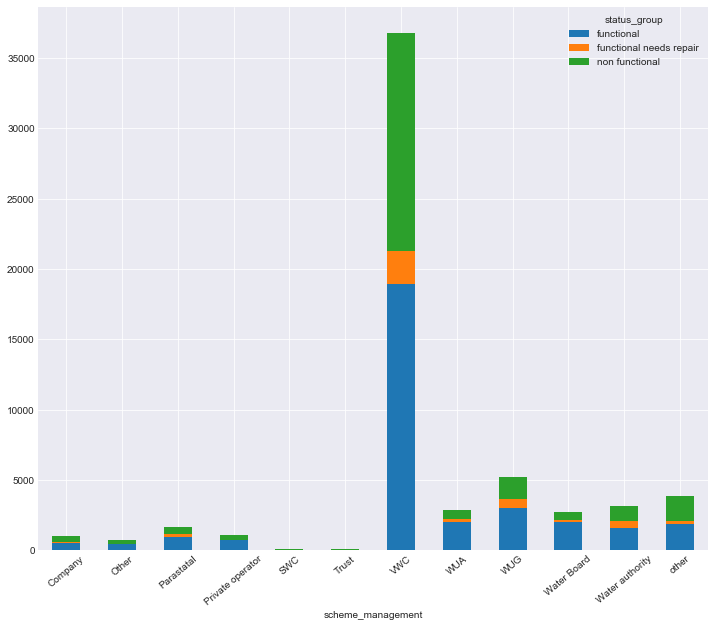

In [122]:
# Different scheme_management affect the status?
plot = plot_df.groupby(['scheme_management', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

In [123]:
# plotting the density of the different status with respect to GPS coordinates

# Split the plot_df into three based on status group
func_df = plot_df.loc[plot_df.status_group == 'functional']
nfunc_df = plot_df.loc[plot_df.status_group == 'non functional']
rfunc_df = plot_df.loc[plot_df.status_group == 'functional needs repair']

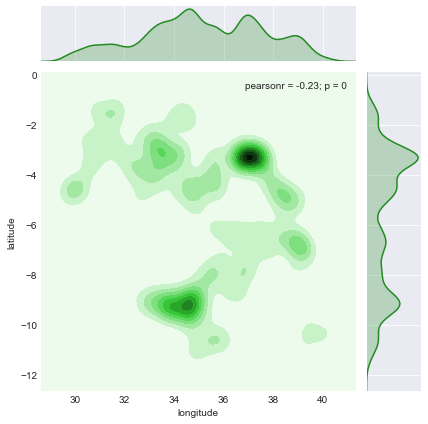

In [124]:
# Geographical distribution of functional pumps 
sns.jointplot(y=func_df['latitude'], x=func_df['longitude'], kind='kde', color='forestgreen')

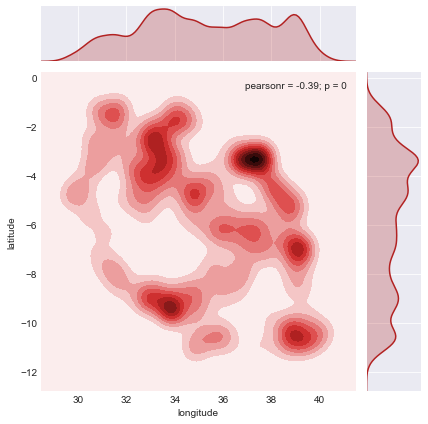

In [125]:
# Geographical distribution of non functional pumps
sns.jointplot(y=nfunc_df['latitude'], x=nfunc_df['longitude'], kind='kde', color='firebrick')

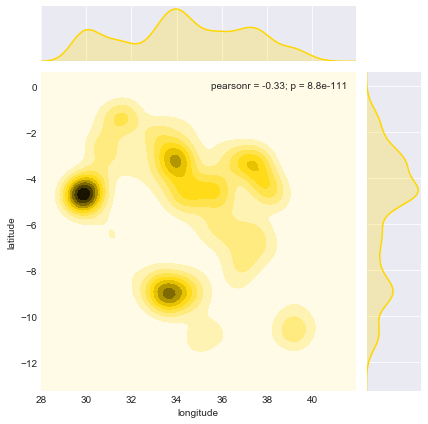

In [126]:
# Geographical distribution of functional/needs repair pumps
sns.jointplot(y=rfunc_df['latitude'], x=rfunc_df['longitude'], kind='kde', color='gold')

In [127]:
# There are clear differences on the distribution of pumps with a different status. 
# => The gps coordinates are likely to be an important feature in the models.

In [128]:
# Trying to visualize the gps height together with the gps coordinates for each status.

from mpl_toolkits.mplot3d import Axes3D

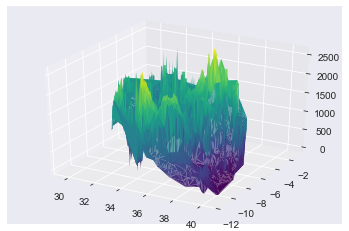

In [129]:
# GPS position and height of functional pumps
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(func_df['longitude'], func_df['latitude'], func_df['gps_height'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

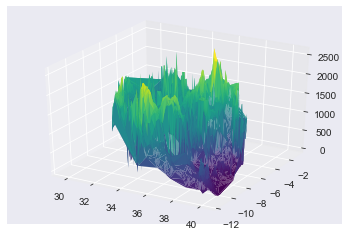

In [130]:
# GPS position and height of non functional pumps
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(nfunc_df['longitude'], nfunc_df['latitude'], nfunc_df['gps_height'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

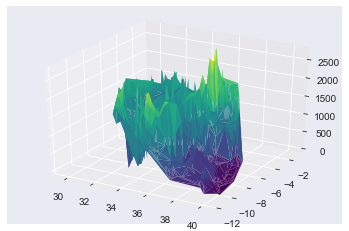

In [131]:
# GPS position and height of functional/needs repair pumps
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(rfunc_df['longitude'], rfunc_df['latitude'], rfunc_df['gps_height'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

In [132]:
# Nice graphs but not very informative

## Preparation for modeling

### Factorization

In [133]:
# Drop the remaining useless columns
all_data = all_data.drop(['id', 'subvillage', 'lga', 'ward'], axis=1)

# List the categorical features
categorical = ['funder',
               'installer',
               'basin',
               'scheme_management',
               'extraction_type_class',
               'management',
               'management_group',
               'payment_type',
               'water_quality',
               'quantity',
               'source',
               'source_class',
               'waterpoint_type']

# And now factorize all the categorical features
for i in categorical:
    all_data[i] = pd.factorize(all_data[i])[0]

### Train-Test split and label factorization

In [134]:
# Splitting train and test
train = all_data[0:len(train_data)]
test = all_data[len(train_data):]

# Dropping the 'id' axis from the target
train_labels = train_labels.drop(['id'], axis=1)

# And factorizing the target
labels = pd.factorize(train_labels.status_group)[0]

## PCA and LDA for visualizing the dataset

In [135]:
# Dimensionality reduction with PCA + LDA to try visualize the dataset in 2/3 dimensions

In [136]:
# Normalizing features
from sklearn.preprocessing import Normalizer

# Defining the normalized
normalizer = Normalizer()

# Fitting normalizer to train set
normalizer.fit(train)
train_norm = normalizer.transform(train)

In [137]:
# Importing PCA library
from sklearn import decomposition
from sklearn import preprocessing

# 10 components PCA
pca = decomposition.PCA(n_components=10)

# Fit PCA to train data
pca.fit(train_norm)
train_pca = pca.transform(train_norm)

In [138]:
# Importing LDA library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Trying to visualize the data in 2 dimensions

# 2 components LDA
LDA = LinearDiscriminantAnalysis(n_components=2, solver='svd')

# Fit LDA to train data
LDA.fit(train_norm, labels)
train_LDA = LDA.transform(train_norm)

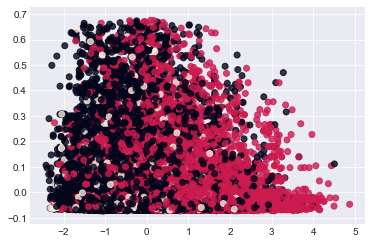

In [139]:
# Scatter plot colored by status group
plt.scatter(train_LDA[:,0], train_pca[:,1], 
            alpha = .8, c=labels);

In [140]:
# 3 components PCA
pca = decomposition.PCA(n_components=3)

# Fit PCA to train data
pca.fit(train_norm)
train_pca = pca.transform(train_norm)

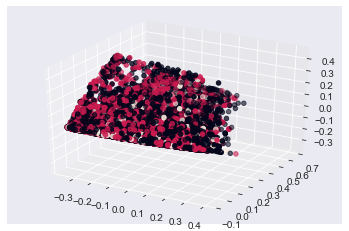

In [141]:
# 3D Scatter plot colored by status group
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train_pca[:,0], train_pca[:,1], train_pca[:,2], c=labels)

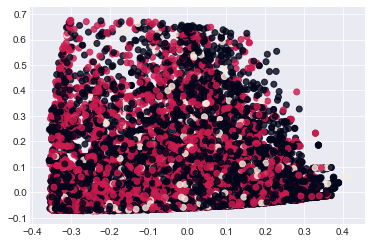

In [142]:
# 2D scatter plots colored by status group x-y axis
plt.scatter(train_pca[:,0], train_pca[:,1], 
            alpha = .8, c=labels);

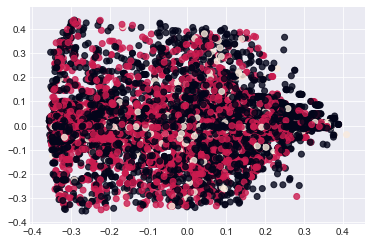

In [143]:
# 2D scatter plots colored by status group x-z axis
plt.scatter(train_pca[:,0], train_pca[:,2], 
            alpha = .8, c=labels);

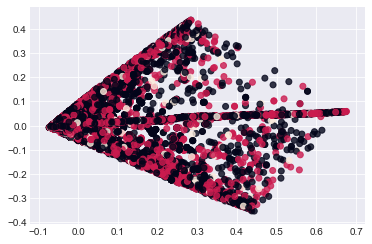

In [144]:
# 2D scatter plots colored by status group x-z axis
plt.scatter(train_pca[:,1], train_pca[:,2], 
            alpha = .8, c=labels);

In [145]:
# Nice try

## Baseline Models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score 

### Train_Test Split for baseline models

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
# split data into train and test sets
seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=test_size, random_state=seed)

### Random Forest Baseline

In [148]:
from sklearn.ensemble import RandomForestClassifier

In [149]:
# Define classifier
forest = RandomForestClassifier(n_estimators=300, random_state=42)

# Fit the model
forest.fit(X_train,y_train)

# make predictions for test data
y_pred = forest.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 79.70%
Precision: 79.06%


In [152]:
# 3 fold cross validation
score = cross_val_score(forest, train, labels, scoring='accuracy', cv=3).mean()
print('3 fold cross-validation score:', score.round(4))

5 fold cross-validation score: 0.7978


In [153]:
# Confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2
0,9359,1020,340
1,1554,5764,140
2,703,223,499


In [154]:
# Variable importance
test_predictions = pd.DataFrame(y_pred)

variable_importance = pd.concat([pd.DataFrame(X_train.columns), 
                                        pd.DataFrame(forest.feature_importances_)], 
                                       axis = 1)

variable_importance.columns = ['variable', 'importance']
variable_importance.sort_values(by='importance', ascending=False)[:10]

,variable,importance
15,quantity,0.109362
3,longitude,0.108417
4,latitude,0.107595
1,gps_height,0.101068
21,population_log,0.067022
22,age,0.053439
9,construction_year,0.052827
18,waterpoint_type,0.051659
10,extraction_type_class,0.049786
0,funder,0.045744


### XGBoost Baseline

In [155]:
from xgboost import XGBClassifier

In [156]:
# Defining Classifier
xgb = XGBClassifier(max_depth=10, n_estimators=300, silent=False, booster='gbtree')

# Fit the model
xgb.fit(X_train, y_train)

# make predictions for test data
y_pred = xgb.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')

# Print the results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 80.34%
Precision: 79.74%


In [152]:
# 3 fold cross validation
score = cross_val_score(xgb, train, labels, scoring='accuracy', cv=3).mean()
print('3 fold cross-validation score:', score.round(4))

5 fold cross-validation score: 0.7978


In [157]:
# Confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2
0,9525,920,274
1,1604,5743,111
2,743,201,481


In [158]:
# Variable importance
test_predictions = pd.DataFrame(y_pred)

variable_importance = pd.concat([pd.DataFrame(X_train.columns), 
                                pd.DataFrame(xgb.feature_importances_)], 
                                    axis = 1)

variable_importance.columns = ['variable', 'importance']
variable_importance.sort_values(by='importance', ascending=False)[:10]

,variable,importance
1,gps_height,0.169176
4,latitude,0.146501
3,longitude,0.144586
21,population_log,0.105744
0,funder,0.071044
9,construction_year,0.060988
2,installer,0.056372
13,payment_type,0.025594
15,quantity,0.025245
22,age,0.023183


## KNN Baseline

In [159]:
from sklearn.neighbors import KNeighborsClassifier 

In [160]:
# split data into train and test test (using the same normalized dataset used for PCA and LDA)
seed = 42
test_size = 0.33
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(train_norm, labels, 
                                                                    test_size=test_size, 
                                                                    random_state=seed)

In [161]:
# Define Classifier
knn = KNeighborsClassifier(n_neighbors=10)

# Fit the model
knn.fit(knn_X_train, knn_y_train)

# make predictions for test data
knn_y_pred = knn.predict(knn_X_test)

# evaluate predictions
accuracy = accuracy_score(knn_y_test, knn_y_pred)
precision = precision_score(knn_y_test, knn_y_pred, average='weighted')

# Print the results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 67.01%
Precision: 65.93%


In [164]:
# 10 fold cross validation
score = cross_val_score(knn, train, labels, scoring='accuracy', cv=10).mean()
print('10 fold cross-validation score:', score.round(4))

10 fold cross-validation score: 0.6768


In [165]:
# Confusion matrix
pd.DataFrame(confusion_matrix(knn_y_test, knn_y_pred))

,0,1,2
0,8876,1700,143
1,3320,4039,99
2,875,329,221


### LDA

In [166]:
# split data into train and test sets (using the same normalized dataset used for PCA and LDA)
seed = 42
test_size = 0.33
LDA_X_train, LDA_X_test, LDA_y_train, LDA_y_test = train_test_split(train_norm, labels, 
                                                                    test_size=test_size, 
                                                                    random_state=seed)

In [167]:
# 2 components LDA
LDA = LinearDiscriminantAnalysis(n_components=2, solver='svd')

# Fit LDA to train data
LDA.fit(LDA_X_train, LDA_y_train)
LDA_X_train = LDA.transform(LDA_X_train)

# make predictions for test data
LDA_y_pred = LDA.predict(LDA_X_test)

# evaluate predictions
accuracy = accuracy_score(LDA_y_test, LDA_y_pred)
precision = precision_score(LDA_y_test, LDA_y_pred, average='weighted')

# Print the results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 63.96%
Precision: 61.62%


In [168]:
# 10 fold cross validation
score = cross_val_score(LDA, train, labels, scoring='accuracy', cv=10).mean()
print('10 fold cross-validation score:', score.round(4))

10 fold cross-validation score: 0.6409


In [169]:
# Confusion matrix
pd.DataFrame(confusion_matrix(LDA_y_test, LDA_y_pred))

,0,1,2
0,8734,1884,101
1,3660,3729,69
2,972,379,74


### KNN after LDA

In [170]:
# Fit LDA to train data
LDA.fit(train_norm, labels)
train_LDA = LDA.transform(train_norm)

In [171]:
# split data into train and test sets
seed = 42
test_size = 0.33
LDA_X_train, LDA_X_test, LDA_y_train, LDA_y_test = train_test_split(train_LDA, labels, 
                                                                    test_size=test_size, 
                                                                    random_state=seed)

In [172]:
# Define classifier
LDA_knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
LDA_knn.fit(LDA_X_train, LDA_y_train)

# make predictions for test data
LDA_y_pred = LDA_knn.predict(LDA_X_test)

# evaluate predictions
accuracy = accuracy_score(LDA_y_test, LDA_y_pred)
precision = precision_score(LDA_y_test, LDA_y_pred, average='weighted')

# Print the results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 65.70%
Precision: 64.15%


In [173]:
# 10 fold cross validation
score = cross_val_score(LDA_knn, train, labels, scoring='accuracy', cv=10).mean()
print('10 fold cross-validation score:', score.round(4))

10 fold cross-validation score: 0.6895


In [174]:
# Confusion matrix
pd.DataFrame(confusion_matrix(LDA_y_test, LDA_y_pred))

,0,1,2
0,8302,2232,185
1,2968,4392,98
2,862,379,184


## Hyperparameter Tuning

In [175]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

### Random Forest

In [176]:
# Defining the classifier
forest = RandomForestClassifier()

In [177]:
# Dfining the parameters distribution for random search

# First search
# Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 30}
# Best score: 0.798

# Second search
# Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 20}
# Best score: 0.7971

# Third search
# Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 20}
# Best score: 0.797251

# Fourth search
# Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 20}
# Best score: 0.797628

# Fifth search
# Best parameters: {'n_estimators': 320, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 22}
# Best score: 0.798332

# Sixth search
# Best parameters: {'n_estimators': 280, 'min_samples_split': 6, 'max_features': 'log2', 'max_depth': 22}
# Best score: 0.798357

param_dist = dict(n_estimators=[280, 300, 320],
                  max_features=['log2', 'sqrt'],
                  max_depth=[18, 20, 22],
                  min_samples_split=[3, 5, 6])

In [178]:
# Defining the random search
cv = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=10, cv=3)

# Fitting the search
cv.fit(X_train, y_train)

# Returning best set of parameter and best cross validated score (accuracy)
print("Best parameters:", cv.best_params_)
print("Best score:", cv.best_score_.round(6))

Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 22}
Best score: 0.797754


In [179]:
# Define classifier
forest = RandomForestClassifier(n_estimators=320, 
                                min_samples_split=5, 
                                max_features='log2', 
                                max_depth=22, 
                                random_state=42)

# Fit the model
forest.fit(train,labels)


# --- Making a submission to check the score => 0.8201

# Predictions
predictions = pd.DataFrame(forest.predict(test))

# Recoding
predictions.loc[predictions[0] == 0] = 'functional'
predictions.loc[predictions[0] == 1] = 'non functional'
predictions.loc[predictions[0] == 2] = 'functional needs repair'

# Concatenating with id
submission = pd.concat([test_data['id'], predictions], axis=1)
submission.columns = ('id', 'status_group')

# Saving file
submission.to_csv('forest_hyped_submission.csv', header=True, index=False)

### XGBoost

In [180]:
# defining the dlassifier
xgb = XGBClassifier()

In [181]:
# First Search
# Best parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.3, 'booster': 'gbtree'}
# Best score: 0.795166

# Second Search
param_dist = dict(n_estimators=[50, 100, 500, 1000],
                  max_depth=[10, 25, 50],
                  learning_rate=[0.1, 0.3, 0.5, 0.7],
                  booster = ['gbtree', 'dart'])
    
# Third Search
param_dist = dict(n_estimators=[50, 250, 500, 1000],
                  max_depth=[10, 20, 40, 50],
                  learning_rate=[0.1, 0.2, 0.3],
                  booster = ['gbtree'])

In [185]:
# Defining the random search --- MODEL Not Ran at the last compilation before submission
# cv = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, cv=3)

# Fitting the search
# cv.fit(X_train, y_train)

# Returning best set of parameter and best cross validated score (accuracy)
# print("Best parameters:", cv.best_params_)
# print("Best score:", cv.best_score_.round(6))

In [187]:
# Define classifier
xgb = XGBClassifier(n_estimators=50, 
                    learning_rate=0.3, 
                    booster='gbtree', 
                    max_depth=10)

# Fit the model
xgb.fit(train,labels)


# Making a submission to check the score => 0.8160

# Predictions
predictions = pd.DataFrame(xgb.predict(test))

# Recoding
predictions.loc[predictions[0] == 0] = 'functional'
predictions.loc[predictions[0] == 1] = 'non functional'
predictions.loc[predictions[0] == 2] = 'functional needs repair'

# Concatenating with id
submission = pd.concat([test_data['id'], predictions], axis=1)
submission.columns = ('id', 'status_group')

# Saving file
submission.to_csv('xgb_hyped_submission.csv', header=True, index=False)

## Model Stacking

In [188]:
from mlxtend.classifier import StackingClassifier

In [189]:
# model 1: random forest with tuned parameters 
clf1 = RandomForestClassifier(n_estimators=320, 
                                min_samples_split=5, 
                                max_features='sqrt', 
                                max_depth=22, 
                                random_state=42)

# model 2: xgboost with tuned parameters
clf2 = XGBClassifier(max_depth=10, 
                     n_estimators=300, 
                     silent=False, 
                     booster='gbtree')

# meta-classifier: random forest
mcl = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=5, 
                                max_features='sqrt', 
                                max_depth=50, 
                                random_state=42)

# defining stacker
sclf = StackingClassifier(classifiers=[clf1, clf2], 
                          meta_classifier=mcl)

In [190]:
# Fitting the model
sclf.fit(X_train, y_train)

StackingClassifier(average_probas=False,
          classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=22, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fra...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)],
          meta_classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          refit=True, store_train_meta_features=False,
          use_features_in_secondary=False, use_probas=Fa

In [191]:
# make predictions for test data
y_pred = sclf.predict(X_test)

In [192]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 80.30%
Precision: 79.64%


In [193]:
# 3 fold cross validation --- MODEL Not Ran at the last compilation before submission
# score = cross_val_score(sclf, train, labels, scoring='accuracy', cv=3).mean()
# print('10 fold cross-validation score:', score.round(4))

In [194]:
# Confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2
0,9325,1081,313
1,1424,5901,133
2,682,228,515


In [195]:
# Variable importance
test_predictions = pd.DataFrame(y_pred)

variable_importance = pd.concat([pd.DataFrame(X_train.columns), 
                                        pd.DataFrame(forest.feature_importances_)], 
                                       axis = 1)

variable_importance.columns = ['variable', 'importance']
variable_importance.sort_values(by='importance', ascending=False)[:10]

,variable,importance
15,quantity,0.131092
3,longitude,0.093044
4,latitude,0.090383
1,gps_height,0.079862
18,waterpoint_type,0.063228
10,extraction_type_class,0.062468
21,population_log,0.056264
22,age,0.054401
9,construction_year,0.053052
0,funder,0.044940


In [196]:
# Fit the model
sclf.fit(train,labels)


# Making a submission to check the score => 0.8178

# Predictions
predictions = pd.DataFrame(sclf.predict(test))

# Recoding
predictions.loc[predictions[0] == 0] = 'functional'
predictions.loc[predictions[0] == 1] = 'non functional'
predictions.loc[predictions[0] == 2] = 'functional needs repair'

# Concatenating with id
submission = pd.concat([test_data['id'], predictions], axis=1)
submission.columns = ('id', 'status_group')

# Saving file
submission.to_csv('forest_xgb_stacked_submission.csv', header=True, index=False)

## Specialized random forests

In [197]:
labels = pd.DataFrame(labels)

In [198]:
labels_f = labels.copy(True)
labels_nf = labels.copy(True)
labels_nr = labels.copy(True)

In [199]:
# Recoding non functional and needs repair to one single factor
labels_f.loc[labels_f[0] == 2] = 1

# Recoding functional and needs repair to one single factor
labels_nf.loc[labels_nf[0] == 0] = 2 # Assign 2 to functional
labels_nf.loc[labels_nf[0] == 1] = 0 # Assigning 0 to non functional
labels_nf.loc[labels_nf[0] == 2] = 1 # Assigning 1 to functional and needs repair

# Recoding functional and non functional to one single factor
labels_nr.loc[labels_nr[0] == 0] = 1 # Assign 1 to functional
labels_nr.loc[labels_nr[0] == 2] = 0 # Assign 0 to needs repair

### Forest For Functional Class

In [200]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train, labels_f, 
                                                    test_size=test_size, 
                                                    random_state=seed)

In [201]:
# Defining the classifier
forest = RandomForestClassifier()

In [202]:
# First Search
# Best parameters: {'n_jobs': -1, 'n_estimators': 1000, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 60, 'class_weight': {0: 1, 1: 1}}
# Best score: 0.813232

param_dist = dict(n_estimators=[100, 300, 500, 1000],
                  max_features=['log2', 'sqrt'],
                  max_depth=[10, 20, 40, 60, 100, 200],
                  min_samples_split=[2, 5, 8, 10, 50],
                  class_weight=[{0:1,1:1},{0:2,1:1},{0:3,1:1}])

In [203]:
# Second search
# Best parameters: {'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 8, 'max_features': 'log2', 'max_depth': 80, 'class_weight': {0: 1, 1: 1}}
# Best score: 0.814262
param_dist = dict(n_estimators=[300, 500, 1000],
                  max_features=['log2', 'sqrt'],
                  max_depth=[40, 60, 80],
                  min_samples_split=[8, 10, 20],
                  class_weight=[{0:1,1:1},{0:2,1:1},{0:3,1:1}],
                  n_jobs=[-1])

In [204]:
# Third search
# Best parameters: {'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 7, 'max_features': 'sqrt', 'max_depth': 90}
# Best score: 0.813734
param_dist = dict(n_estimators=[200, 300, 400],
                  max_features=['log2', 'sqrt'],
                  max_depth=[70, 80, 90],
                  min_samples_split=[7, 8, 9],
                  n_jobs=[-1])

In [205]:
# Fourth search
# Best parameters: {'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 8, 'max_features': 'log2', 'max_depth': 95}
# Best score: 0.813885
param_dist = dict(n_estimators=[250, 300, 350],
                  max_features=['log2', 'sqrt'],
                  max_depth=[85, 90, 95],
                  min_samples_split=[7, 8, 9],
                  n_jobs=[-1])

In [206]:
# Defining the random search
cv = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=10, cv=3)

# Fitting the search
# cv.fit(X_train, y_train) --- search not fitted in last compilation before submission

# Returning best set of parameter and best cross validated score (accuracy)
# print("Best parameters:", cv.best_params_)
# print("Best score:", cv.best_score_.round(6))

In [207]:
# Define classifier with parameters from grid search
forest = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=95,
                                random_state=42)

# Fit the model
forest.fit(X_train,y_train)

# make predictions for test data
y_pred = forest.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 81.98%
Precision: 82.01%


In [208]:
# 3 fold cross validation --- cv not ran during last compilation before submission
# score = cross_val_score(forest, train, labels, scoring='accuracy', cv=3).mean()
# print('3 fold cross-validation score:', score.round(4))

In [209]:
# Confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,9284,1435
1,2098,6785


In [210]:
# Variable importance
test_predictions = pd.DataFrame(y_pred)

variable_importance = pd.concat([pd.DataFrame(X_train.columns), 
                                        pd.DataFrame(forest.feature_importances_)], 
                                       axis = 1)

variable_importance.columns = ['variable', 'importance']
variable_importance.sort_values(by='importance', ascending=False)[:10]

,variable,importance
15,quantity,0.127911
3,longitude,0.091704
4,latitude,0.089319
1,gps_height,0.079641
18,waterpoint_type,0.064694
10,extraction_type_class,0.059670
22,age,0.058429
9,construction_year,0.057586
21,population_log,0.054884
0,funder,0.047174


### Forest For Non Functional Class

In [211]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train, labels_nf, 
                                                    test_size=test_size, 
                                                    random_state=seed)

In [212]:
# Defining the classifier
forest = RandomForestClassifier()

In [213]:
# First Search
# Best parameters: {'n_jobs': -1, 'n_estimators': 1000, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 60, 'class_weight': {0: 1, 1: 1}}
# Best score: 0.852631
param_dist = dict(n_estimators=[100, 300, 500, 1000],
                  max_features=['log2', 'sqrt'],
                  max_depth=[10, 20, 40, 60, 100, 200],
                  min_samples_split=[2, 5, 8, 10, 50],
                  class_weight=[{0:1,1:1},{0:2,1:1},{0:3,1:1}])



In [214]:
# Second Search
# Best parameters: {'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 40, 'class_weight': {0: 1, 1: 1}}
# Best score: 0.853158
param_dist = dict(n_estimators=[300, 500, 1000],
                  max_features=['log2', 'sqrt'],
                  max_depth=[40, 60, 80],
                  min_samples_split=[3, 5, 7],
                  class_weight=[{0:1,1:1},{0:2,1:1},{0:3,1:1}],
                  n_jobs=[-1])

In [215]:
# Third search
# Best parameters: {'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 60}
# Best score: 0.852882
param_dist = dict(n_estimators=[200, 300, 400],
                  max_features=['log2', 'sqrt'],
                  max_depth=[20, 40, 60],
                  min_samples_split=[4, 5, 6],
                  n_jobs=[-1])

In [216]:
# Fourth search
param_dist = dict(n_estimators=[250, 300, 350],
                  max_features=['log2', 'sqrt'],
                  max_depth=[50, 60, 70],
                  min_samples_split=[4, 5, 6],
                  n_jobs=[-1])

In [217]:
# Defining the random search
cv = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=10, cv=3)

# Fitting the search
# cv.fit(X_train, y_train) --- search not fitted during last compilation before submission

# Returning best set of parameter and best cross validated score (accuracy)
# print("Best parameters:", cv.best_params_)
# print("Best score:", cv.best_score_.round(6))

In [218]:
# Define classifier with parameters from grid search
forest = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=5,
                                max_features='log2',
                                max_depth=50,
                                random_state=42)

# Fit the model
forest.fit(X_train,y_train)

# make predictions for test data
y_pred = forest.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 85.76%
Precision: 85.74%


In [219]:
# 3 fold cross validation --- cv not ran during last compilation before submission
# score = cross_val_score(forest, train, labels, scoring='accuracy', cv=3).mean()
# print('3 fold cross-validation score:', score.round(4))

In [220]:
# Confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,5620,1838
1,954,11190


In [221]:
# Variable importance
test_predictions = pd.DataFrame(y_pred)

variable_importance = pd.concat([pd.DataFrame(X_train.columns), 
                                        pd.DataFrame(forest.feature_importances_)], 
                                       axis = 1)

variable_importance.columns = ['variable', 'importance']
variable_importance.sort_values(by='importance', ascending=False)[:10]

,variable,importance
15,quantity,0.147193
4,latitude,0.090214
3,longitude,0.086573
1,gps_height,0.076437
10,extraction_type_class,0.068889
18,waterpoint_type,0.063224
21,population_log,0.054372
22,age,0.054325
9,construction_year,0.052369
0,funder,0.042924


### Forest for functional needs repair

In [222]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train, labels_nr, 
                                                    test_size=test_size, 
                                                    random_state=seed)

In [223]:
# Defining the classifier
forest = RandomForestClassifier()

In [224]:
# First Search
# Best parameters: {'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 8, 'max_features': 'log2', 'max_depth': 60, 'class_weight': {0: 1, 1: 1}}
# Best score: 0.93462
param_dist = dict(n_estimators=[100, 300, 500, 1000],
                  max_features=['log2', 'sqrt'],
                  max_depth=[10, 20, 40, 60, 100, 200],
                  min_samples_split=[2, 5, 8, 10, 50],
                  class_weight=[{0:1,1:1},{0:2,1:1},{0:3,1:1}])

In [225]:
# Second search
# Best parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_features': 'log2', 'max_depth': 60, 'class_weight': {0: 1, 1: 1}}
# Best score: 0.935047
param_dist = dict(n_estimators=[100, 300, 500],
                  max_features=['log2', 'sqrt'],
                  max_depth=[40, 60, 80],
                  min_samples_split=[6, 8, 10],
                  class_weight=[{0:1,1:1},{0:2,1:1},{0:3,1:1}])

In [226]:
# Third search
# Best parameters: {'n_jobs': -1, 'n_estimators': 50, 'min_samples_split': 9, 'max_features': 'sqrt', 'max_depth': 60}
# Best score: 0.934846
param_dist = dict(n_estimators=[50, 100, 200],
                  max_features=['log2', 'sqrt'],
                  max_depth=[40, 60, 80],
                  min_samples_split=[7, 8, 9],
                  n_jobs=[-1])

In [227]:
# Fourth search
# Best parameters: {'n_jobs': -1, 'n_estimators': 50, 'min_samples_split': 8, 'max_features': 'log2', 'max_depth': 70}
# Best score: 0.935298
param_dist = dict(n_estimators=[50, 60, 70],
                  max_features=['log2', 'sqrt'],
                  max_depth=[50, 60, 70],
                  min_samples_split=[8, 9, 10],
                  n_jobs=[-1])

In [228]:
# Defining the random search
cv = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=10, cv=3)

# Fitting the search
# cv.fit(X_train, y_train) --- search not fitted during last compilation before submission

# Returning best set of parameter and best cross validated score (accuracy)
# print("Best parameters:", cv.best_params_)
# print("Best score:", cv.best_score_.round(6))

In [229]:
# Define classifier with parameters from grid search
forest = RandomForestClassifier(n_estimators=50, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=70,
                                random_state=42)

# Fit the model
forest.fit(X_train,y_train)

# make predictions for test data
y_pred = forest.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 93.59%
Precision: 92.29%


In [230]:
# 3 fold cross validation --- cv not ran during last compilation before submission
# score = cross_val_score(forest, train, labels, scoring='accuracy', cv=3).mean()
# print('3 fold cross-validation score:', score.round(4))

In [231]:
# Confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,359,1066
1,191,17986


In [232]:
# Variable importance
test_predictions = pd.DataFrame(y_pred)

variable_importance = pd.concat([pd.DataFrame(X_train.columns), 
                                        pd.DataFrame(forest.feature_importances_)], 
                                       axis = 1)

variable_importance.columns = ['variable', 'importance']
variable_importance.sort_values(by='importance', ascending=False)[:10]

,variable,importance
3,longitude,0.142328
4,latitude,0.126827
1,gps_height,0.111839
21,population_log,0.083872
0,funder,0.057869
9,construction_year,0.055602
22,age,0.055106
2,installer,0.044549
13,payment_type,0.043197
15,quantity,0.032866


### Stacking the forests

In [233]:
from sklearn.linear_model import LogisticRegression

In [234]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train, labels, 
                                                    test_size=test_size, 
                                                    random_state=seed)

In [235]:
# forest for functional
forest_functional = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=95,
                                random_state=42)

# forest for non functional
forest_nonfunctional = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=5,
                                max_features='log2',
                                max_depth=50,
                                random_state=42)

# forest for needs repair
forest_needsrepair = RandomForestClassifier(n_estimators=50, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=70,
                                random_state=42)

# meta-classifier: logistic regression
stacker = LogisticRegression(penalty='l2', 
                             solver='newton-cg', 
                             multi_class='multinomial')

# defining the stacker
sclf = StackingClassifier(classifiers=[forest_functional, forest_nonfunctional, forest_needsrepair], 
                          meta_classifier=stacker)

In [236]:
# fitting the model
sclf.fit(X_train, y_train)

StackingClassifier(average_probas=False,
          classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=95, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fra...estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
          refit=True, store_train_meta_features=False,
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [237]:
# make predictions for test data
y_pred = sclf.predict(X_test)

In [238]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 80.54%
Precision: 79.88%


In [239]:
# 3 fold cross validation --- cv not ran during last compilation before submission
# score = cross_val_score(sclf, train, labels, scoring='accuracy', cv=3).mean()
# print('3 fold cross-validation score:', score.round(4))

In [240]:
# Confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2
0,9557,920,242
1,1584,5768,106
2,733,230,462


In [241]:
# Variable importance
test_predictions = pd.DataFrame(y_pred)

variable_importance = pd.concat([pd.DataFrame(X_train.columns), 
                                        pd.DataFrame(forest.feature_importances_)], 
                                       axis = 1)

variable_importance.columns = ['variable', 'importance']
variable_importance.sort_values(by='importance', ascending=False)[:10]

,variable,importance
3,longitude,0.142328
4,latitude,0.126827
1,gps_height,0.111839
21,population_log,0.083872
0,funder,0.057869
9,construction_year,0.055602
22,age,0.055106
2,installer,0.044549
13,payment_type,0.043197
15,quantity,0.032866


In [242]:
# Fit the model
sclf.fit(train,labels)


# Making a submission to check the score => 0.8180

# Predictions
predictions = pd.DataFrame(sclf.predict(test))

# Recoding
predictions.loc[predictions[0] == 0] = 'functional'
predictions.loc[predictions[0] == 1] = 'non functional'
predictions.loc[predictions[0] == 2] = 'functional needs repair'

# Concatenating with id
submission = pd.concat([test_data['id'], predictions], axis=1)
submission.columns = ('id', 'status_group')

# Saving file
submission.to_csv('3forest_stacked_submission2.csv', header=True, index=False)